# Unmyelinated neuron fiber model

## Objectives
- Create unmyelinated neuron fiber model based on myelinated case.
- Check simulated treshold current convergence dependence on the node length.
- Run the simulations for the obtained node length.
- Calculate conduction velocity.
- Compute a strength-duration curve and calculate the chronaxie.

## Rationale
To move from the myelinated case to unmyelinated case the main assumption we made in the model is that now the internodal length will be equal to 0. That is how we make sure that there is no myelin sheat included in the model. For a given fiber length there might be a different number of nodes. This will affect the treshold current needed to elicit action potential. If the node length is too big, the action potential does not propagate. If the node length is too small, the computation time of the simulations rises drastically. That is why it is needed to find a node length treshold. For these purposes, the node length when the treshold current value converges is found. Thus, twith the following increase in the number of nodes the stimulation results will be the same.

## Imports

In [1]:
import os
import logging
import numpy as np
import matplotlib.pyplot as plt
from convergence import convergence

from PySONIC.neurons import getPointNeuron
from PySONIC.utils import logger, si_format
from ExSONIC.core import IinjUnmyelinatedSennFiber, IntracellularCurrent
from ExSONIC.test import TestFiber
from ExSONIC.plt import SectionCompTimeSeries, strengthDurationCurve

#Set logging level
import logging
logger.setLevel(logging.WARNING)

Let's define the model parameters:

In [2]:
# Fiber model parameters
pneuron = getPointNeuron('FH')       # mammalian fiber membrane equations
fiberD = 10e-6                       # fiber diameter (m)
rho_a = 54.7                         # axoplasm resistivity (Ohm.cm)
d_ratio = 0.6                        # axon / fiber diameter ratio
fiberL = 1e-2                       # fiber length (m) 

# Intracellular stimulation parameters
tstim = 10e-6   # s
toffset = 3e-2  # s
PRF = 100.      # Hz
DC = 1.         # -

Create an intracellular current (stimulation of the first node):

In [3]:
psource = IntracellularCurrent(0, mode='anode')

Run the convergence detection function:

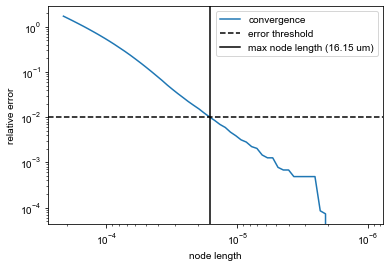

In [4]:
#Choose the number of nodes range
nnodes = np.logspace(0, 4, 100)
nnodes = np.asarray(np.ceil(nnodes) // 2 * 2 + 1, dtype=int)

#run the convergence
Ithrs = convergence(pneuron, fiberD, rho_a, d_ratio, fiberL, tstim, toffset, PRF, DC, psource, nnodes)

#Recalculate number of nodes to node length and 
nodeL = fiberL / nnodes
Ithr_ref = Ithrs[-1]
rel_errors = (Ithrs - Ithr_ref) / Ithr_ref
max_rel_error = 0.01
max_nodeL = np.interp(max_rel_error, rel_errors[::-1], nodeL[::-1], left=np.nan, right=np.nan)

#PLotting
fig = plt.plot(nodeL, rel_errors, label='convergence')
plt.xlabel('node length')
plt.ylabel('relative error')
plt.xscale('log')
plt.yscale('log')
plt.axhline(max_rel_error, label='error threshold', color='k', linestyle='--')
plt.axvline(max_nodeL, label=f'max node length ({max_nodeL * 1e6:.2f} um)', color='k')
plt.gca().invert_xaxis()
plt.legend()

The treshold current convergence is shown on the graph above. The relative error (the difference of the treshold current value to the convergence value in percent) rises with the node length. This behaviour is expected as with the rise of the node length it is harder for action potential to propagate. The maximum relative error used here is 1% (shown as a dashed line in the graph). The maximal node length is 16.15 ${\mu}m$, which leads to the aprroximately 1 min computation time per simulation. 

## Simulations
In this section we run the simulation for the found maximal node length and stimulation current 1.2 above the treshold amplitude. For the imaging purposes we will plot every fifth action potential trace.

In [5]:
min_nnodes = int(fiberL / max_nodeL)
fiber = IinjUnmyelinatedSennFiber(pneuron, fiberD, nnodes=min_nnodes, rs=rho_a, fiberL=fiberL, d_ratio=d_ratio)
logger.info(f'Running titration for {si_format(tstim)}s pulse')
Ithr = fiber.titrate(psource, tstim, toffset, PRF, DC)  # m/s
data, meta = fiber.simulate(psource, 1.2*Ithr, tstim, toffset, PRF, DC)

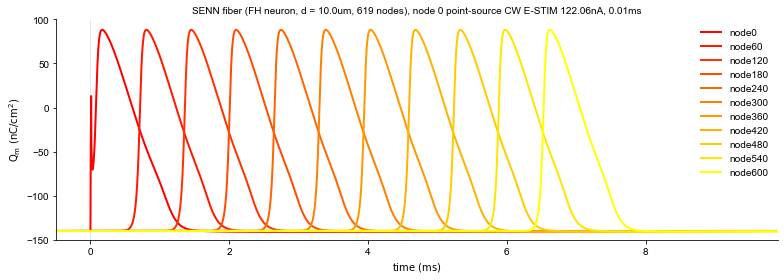

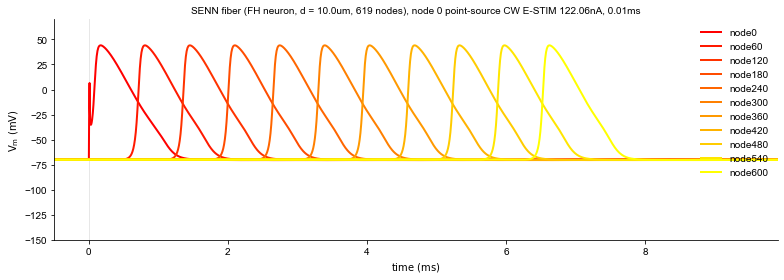

In [6]:
trange = (-0.5e-3, 10e-3)
fig1 = SectionCompTimeSeries([(data, meta)], 'Qm', fiber.ids[::60]).render(trange=trange)
fig2 = SectionCompTimeSeries([(data, meta)], 'Vm', fiber.ids[::60]).render(trange=trange)

In [7]:
cv = fiber.getConductionVelocity(data)
print(f'cv = {cv:.2f} m/s')

cv = 1.52 m/s


As we can see, the behaviour of unmyelinated SENN neuron fiber is in a good correspondence to FH neurons in myelinated case. The form of the action potentials is the same as described in literature. The first bump can be described as the moment of a rapid voltage change due to turning the stimulation on. The conduction velocity is approximately 10 times less than for myelinated case (Neuroscience, Dale Purves et al.). However, it is not the same as in Sundt et al. 2015 paper (0.28 - 0.54 m/s) as the equations governing the membrane processes are different for FH neuron. <br>
It is worth noting that conduction velocity value is in range for mammalian neurons with non-myelinated fibers (group IV neurons): from 0.71 to 1.76 m/s based on the results in Hoheisel U. and Mense S. 1986.

## Strength-duration curve
Let's compute the threshold injecting current required to excite the fiber, for various stimulus durations:

rheobase = 8.55e-09 A
chronaxie = 0.015 ms


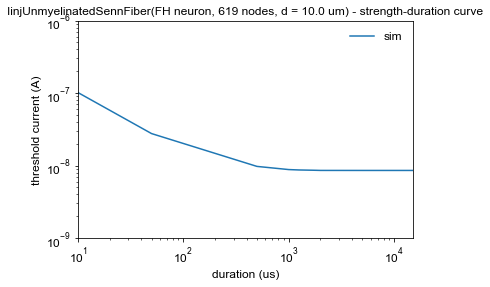

In [9]:
# Strength-duration curve
fiber.reset()
durations = np.array([10, 50, 500, 1000, 1250, 1750, 2000, 2250, 2500, 5000, 6000, 7000, 8000, 9000, 10000, 15000], dtype=float) * 1e-6  # s
Ithrs = np.array([fiber.titrate(psource, x, toffset, PRF, DC) for x in durations])
fig = strengthDurationCurve(
    fiber, durations, {'sim': np.array(Ithrs)}, scale='log', plot_chr=False,
    yname='current', yfactor=1e0, yunit='A')

#Calculating chronaxie
rheobase = np.min(Ithrs) # m/s
rheobase2 = 2*rheobase
print(f'rheobase = {np.min(Ithrs)} A')
print(f'chronaxie = {np.interp(rheobase2, Ithrs, durations)} ms')

As can be seen from the graph the treshold current required to excite the fiber falls and converges with the stimulus duration. The chronaxie is calculated and shown.

## Conclusions
- The unmyelinated neuron fiber model is created based on the idea of 0 internodal distance.
- The maximal node length needed for the simulations is 16.15 ${\mu}m$ for a 1% relative error case.
- Unmyelinated neuron fiber is simulated for the found minimal number of nodes.
- Conduction velocity is approximately 10 times less than for myelinated fiber.
- The strength-duration curve obtained from the simulation data makes empirical sense.

## References

 - Dale Purves, George J Augustine, David Fitzpatrick, Lawrence C Katz, Anthony-Samuel LaMantia, James O McNamara, and S Mark Williams, "Neuroscience", 2nd Edition, Sunderland (MA): Sinauer Associates, 2001. https://www.ncbi.nlm.nih.gov/books/NBK10921/
 - Sundt D, Gamper N, Jaffe DB., "Spike propagation through the dorsal root ganglia in an unmyelinated sensory neuron: a modeling study", J Neurophysiol 114: 3140–3153, 2015. https://www.ncbi.nlm.nih.gov/pubmed/26334005
 - Hoheisel U, Mense S. Non-myelinated afferent fibres do not originate exclusively from the smallest dorsal root ganglion cells in the cat. Neurosci Lett 72: 153–157, 1986. https://www.sciencedirect.com/science/article/pii/0304394086900716?via%3Dihub